In [186]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import umap

from rdkit.Chem import MolFromSmiles, DataStructs
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [55]:
w = torch.load('../analysis/DDC_best_epoch_23.ckpt', map_location=torch.device('cpu'))

In [56]:
d_enc = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU())

In [57]:
d_enc.load_state_dict({k[10:]: v for k, v in w['state_dict'].items() if k.startswith('d_encoder')}, strict=False)

<All keys matched successfully>

In [58]:
d_enc

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
)

In [99]:
kiba_ddc = pd.read_csv('../analysis/kiba_cliff_pairs_ta1_ts0.9_r_wt.csv')

In [84]:
kiba_ddc

,Unnamed: 0,drug1,drug2,cliff,target,smiles1,smiles2,split
0,35134,CHEMBL1980178,CHEMBL1995712,0,177,CC(=O)NC1CCCC(C1)NC2=NC(=CC(=N2)Cl)C3=CNC4=C3C...,CN(C)CC(=O)NC1CCCC(C1)NC2=NC(=CC(=N2)Cl)C3=CNC...,0
1,14569,CHEMBL1983963,CHEMBL394619,0,2,CC1=CC(=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=COC4=NC=N...,CC1=CC(=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,0
2,15884,CHEMBL1968406,CHEMBL1982135,0,168,CCC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)S...,CC1=CC=CC=C1NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)SC5=...,0
3,7058,CHEMBL1242373,CHEMBL1968406,0,12,CC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)SC...,CCC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)S...,0
4,46382,CHEMBL1970142,CHEMBL2001485,0,154,CC1=CC=C(C=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,CC1=CC=C(C=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,0
...,...,...,...,...,...,...,...,...
80512,63795,CHEMBL1990254,CHEMBL1986143,0,56,C1=CC=C(C=C1)C(CN)NC(=O)C2=CC=C(C=C2)C3=CC=NC=C3,C1=CC=C(C=C1)C(CCO)NC(=O)C2=CC=C(C=C2)C3=CC=NC=C3,2
80513,35876,CHEMBL377383,CHEMBL424872,0,118,CCOC1=C(C(=CC(=N1)C(=O)NCC2=CC=C(C=C2)S(=O)(=O...,CCOC1=C(C(=CC(=N1)C(=O)NCC2=CC=C(C=C2)S(=O)(=O...,2
80514,23515,CHEMBL1971149,CHEMBL1991678,0,188,CC1=NC=CN2C1=NC(=C2C3=NC(=NC=C3)NCC(C)(C)C(=O)...,CC1=NC=CN2C1=NC(=C2C3=NC(=NC=C3)NCC(C)(C)CO)C4...,2
80515,18871,CHEMBL1964444,CHEMBL1980540,0,182,CC1=CC2=C(C=CN=C2C=C1)NC(=O)NC3=CC=CC(=N3)C(F)...,C1=CC2=C(C=CN=C2C(=C1)Cl)NC(=O)NC3=CC=CC(=N3)C...,2


In [87]:
kiba_ddc['target'].unique().sum()

24531

In [89]:
target_pairs_count = kiba_ddc.groupby('target').apply(lambda x: x[['drug1', 'drug2']].apply(frozenset, axis=1).nunique())

C:\Users\regin\AppData\Local\Temp\ipykernel_11008\473478439.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_pairs_count = kiba_ddc.groupby('target').apply(lambda x: x[['drug1', 'drug2']].apply(frozenset, axis=1).nunique())


In [90]:
target_pairs_count

target
0      457
1      369
2      686
3      278
4      382
      ... 
217    503
218    452
219    493
220    524
221    522
Length: 222, dtype: int64

In [109]:
t70 = kiba_ddc[kiba_ddc['target'] == 70]

In [110]:
t70['drug1'].value_counts()

drug1
CHEMBL1241487    26
CHEMBL1241676    26
CHEMBL1241483    25
CHEMBL1241485    25
CHEMBL1233882    24
                 ..
CHEMBL1972584     1
CHEMBL460989      1
CHEMBL1970709     1
CHEMBL1971649     1
CHEMBL1975500     1
Name: count, Length: 538, dtype: int64

In [115]:
t70[t70['drug1']=='CHEMBL1241487']['cliff'].value_counts()

cliff
0    18
1     8
Name: count, dtype: int64

In [119]:
t70_d1_d = t70[t70['drug1']=='CHEMBL1241487']

In [205]:
t70_d1_d

,Unnamed: 0,drug1,drug2,cliff,target,smiles1,smiles2,split
1148,28519,CHEMBL1241487,CHEMBL1242202,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)OC)O)C(=NC=N3)N,0
4059,28518,CHEMBL1241487,CHEMBL1242199,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=CC(=C4)F)O)C(=NC=N3)N,0
4266,28533,CHEMBL1241487,CHEMBL1242750,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCCC(CC1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0
19853,28516,CHEMBL1241487,CHEMBL1241859,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N,0
29015,28530,CHEMBL1241487,CHEMBL1242658,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0
29999,28534,CHEMBL1241487,CHEMBL1242844,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0
36103,28528,CHEMBL1241487,CHEMBL1242656,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0
37195,28517,CHEMBL1241487,CHEMBL1242111,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCC(C1)N2C3=C(C(=N2)C4=C(C(=CC=C4)O)F)C(=NC=N3)N,0
39550,28520,CHEMBL1241487,CHEMBL1242287,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)Br)O)C(=NC=N3)N,0
40186,28512,CHEMBL1241487,CHEMBL1241678,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1COCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N,0


In [210]:
dr1 = pd.DataFrame({'drug1': ['CHEMBL1241487'], 
                    'drug2': ['CHEMBL1241487'], 
                    'cliff': [2], 
                    'target': [70], 
                    'smiles1': ['C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N'], 
                    'smiles2': ['C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N']})

t70_d1_d = pd.concat([t70_d1_d, dr1], axis=0)

In [212]:
t70_d1_d

,Unnamed: 0,drug1,drug2,cliff,target,smiles1,smiles2,split
1148,28519.0,CHEMBL1241487,CHEMBL1242202,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)OC)O)C(=NC=N3)N,0.0
4059,28518.0,CHEMBL1241487,CHEMBL1242199,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=CC(=C4)F)O)C(=NC=N3)N,0.0
4266,28533.0,CHEMBL1241487,CHEMBL1242750,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCCC(CC1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0.0
19853,28516.0,CHEMBL1241487,CHEMBL1241859,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N,0.0
29015,28530.0,CHEMBL1241487,CHEMBL1242658,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0.0
29999,28534.0,CHEMBL1241487,CHEMBL1242844,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0.0
36103,28528.0,CHEMBL1241487,CHEMBL1242656,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N,0.0
37195,28517.0,CHEMBL1241487,CHEMBL1242111,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CCC(C1)N2C3=C(C(=N2)C4=C(C(=CC=C4)O)F)C(=NC=N3)N,0.0
39550,28520.0,CHEMBL1241487,CHEMBL1242287,1,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1CC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)Br)O)C(=NC=N3)N,0.0
40186,28512.0,CHEMBL1241487,CHEMBL1241678,0,70,C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)N)O)C(=NC=N3)N,C1COCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N,0.0


In [213]:
smiles = t70_d1_d['smiles2'].tolist()

In [214]:
len(smiles)

27

In [215]:
smiles

['CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)OC)O)C(=NC=N3)N',
 'C1CCC(C1)N2C3=C(C(=N2)C4=CC(=CC(=C4)F)O)C(=NC=N3)N',
 'C1CCCC(CC1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N',
 'C1CNCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1CNCCC1CN2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'CC1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1CCC(C1)N2C3=C(C(=N2)C4=C(C(=CC=C4)O)F)C(=NC=N3)N',
 'C1CC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)Br)O)C(=NC=N3)N',
 'C1COCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N',
 'C1CC(NC1)CN2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N',
 'C1CCC(C1)N2C3=C(C(=N2)C4=CC(=C(C=C4)Br)O)C(=NC=N3)N',
 'C1C(CN1)N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1CCC(C1)N2C3=C(C(=N2)C4=CC5=C(C=C4)NN=C5)C(=NC=N3)N',
 'C1CCC(C1)N2C3=C(C(=N2)C4=CC5=C(C=C4)C=NN5)C(=NC=N3)N',
 'C1CNCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)Cl)O)C(=NC=N3)N',
 'C1CNCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1COCC1N2C3=C(C(=N2)C4=CC(=C(C=C4)F)O)C(=NC=N3)N',
 'C1CC

In [217]:
features = []
for s in smiles:    
    mol = MolFromSmiles(s)
    if mol is not None:
        fp = GetMorganFingerprintAsBitVect(mol, 2, 1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        features.append(torch.tensor(arr, dtype=torch.float32))
    else:
        print(s)

In [218]:
features

[tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0.,

In [219]:
len(features)

27

In [220]:
torch.stack(features)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [221]:
out = d_enc(torch.stack(features)).detach().numpy()

In [222]:
out.shape

(27, 1024)

In [224]:
u = umap.UMAP()

In [225]:
umap_res = u.fit_transform(out)

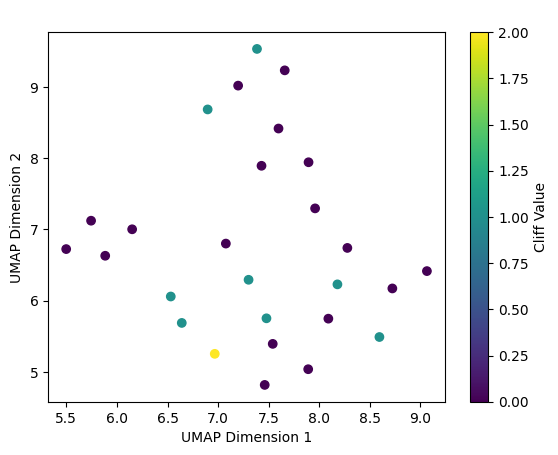

In [226]:
plt.scatter(umap_res[:, 0], umap_res[:, 1], c = t70_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cliff Value')
plt.show()